## Objective of this Assignment

The goal of this assignment is to learn two, very important topics in deep learning.

* Data Invariance and Building Robust Models
* Transfer Learning

## Data Invariance and Building Robust Models

In this part of the assignment you will learn about Data Invariance and  model prediction with a simple example of MNIST dataset.

Let's start with a simple example to understand what invariance is. As a human, we are invariant to read a sentence when it is writen in a different angle, orientation, if the sentense is flipped in an unusual direction, or even if the image is blurred (Augmentated) to some scale. But this is not the case for machine learning. If a machine learning model is not trained with augmentated data, the model won't be data invariant and will fail miserably in some cases.

So, to put it formally, Invariance to a transformation group(Image Augmentation) in Neural Networks can simply be defined as invariance(not-changing) of Neural Networks output with respect to this group acting on the input.

Many real world data analysis problems exhibit invariant structure, and models that take advantage of this structure have shown impressive empirical performance, particularly in deep learning. In this assignment, we analyze the benefits of data augmentation as a technique to make the model invariant to different input images.

Please read the following articles for a more deeper understanding [Article](https://towardsdatascience.com/invariance-causality-and-robust-deeplearning-df8db9091627) and
[Paper](https://arxiv.org/pdf/2005.00178.pdf)


In [ ]:
# Let's start with importing some necessary libraries

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

print(tf.__version__)

2.13.0


## Dataset Loading

In this section we will load the MNIST dataset with **80:10:10** training, test and validation split and visualize the dataset. You can change the split ratio differently if you want. Smaller size of training data will normally lead to a bad training model with relatively lower accuracy. Running the following cell will yield the number of classes and you can see a sample dataset from MNIST.


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Number of classes we want to classify 10
<class 'tensorflow.python.framework.ops.EagerTensor'>


'\nfor train in train_ds:\n    X, y = train\n    # variable train is a tuple\n    # X is the image and y is the label\n    # write your stuffs here\n\n'

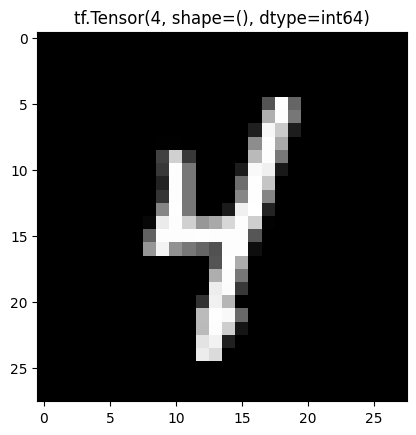

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'mnist',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

num_classes = metadata.features['label'].num_classes
print("Number of classes we want to classify", num_classes)

get_label_name = metadata.features['label'].int2str

#print(metadata)
# Get a sample image and label

image, label = next(iter(train_ds))
print(type(image))
image_show = np.squeeze(image)
plt.imshow(image_show, cmap='gray')
plt.title(get_label_name(label))



# You can iterate over the whole trainig set in the following way as well
# Remove the quotes from the following section to iterate over the train_ds
# and play with the dataset
"""
for train in train_ds:
    X, y = train
    # variable train is a tuple
    # X is the image and y is the label
    # write your stuffs here

"""

## Data Scaling and Rotation

Out of sample image means, it is highly different from the original training set. The distribution of out-of-sample data can be different, or they may have a different orientation, flip, brighhtness. Now we will see some examples of how we can rescale, flip and rotate an image. In tensorflow we can create a Sequential Layer with these functionalities and the rest will be taken care automatically by TensorFlow.

There are a variety of preprocessing layers you can use for data augmentation including *tf.keras.layers.RandomContrast*, *tf.keras.layers.RandomCrop*, *tf.keras.layers.RandomZoom*, and others.

In the following example, we will write a Sequential layer where we will resize and rescale an image and see the output.

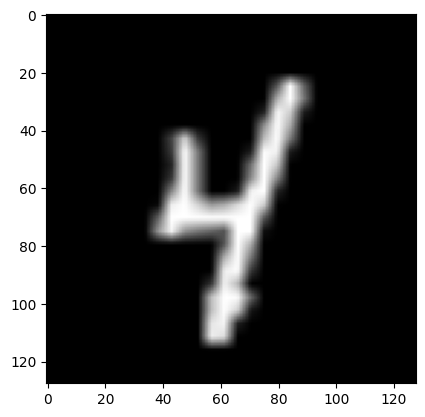

In [ ]:
# Rescaling the Image
IMG_SIZE = 128
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255) ])

# Resccaling will not change how the image looks. It only divides the pixel values by 255.
# So all the pixel values are between 0 and 1
result = resize_and_rescale(image, label)

plt.imshow(np.squeeze(result), cmap='gray')

Now we are going to create another Sequential Layer to Flip and randomly rotate 50% of the images and see how the rotation/flip looks like. Run the following cell and see the output. We will put the same image in our *data_augmentation* sequential layer. You will see that, the images are still recognizable by a human eye. We can safely say that the number in the images are 4. But if we don't use these rotated images in our training dataset, the model will have a very hard time prediccting the correct output.


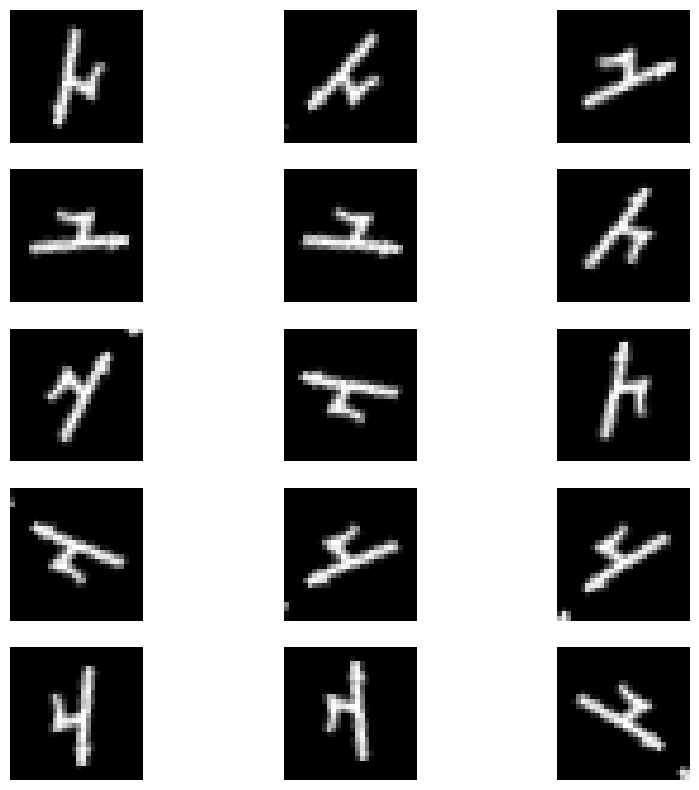

In [ ]:
data_flip_and_rotation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.5),
])

plt.figure(figsize=(10, 10))
for i in range(15):
    augmented_image = data_flip_and_rotation(tf.expand_dims(image, 0))
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(np.squeeze(augmented_image[0]), cmap='gray')
    plt.axis("off")

Now we are going to write a function called *data_augment* that will resize, rescale, shuffle and flip and rotate the images based on 2 paremeters,  and create batches of data. Default batch size is 32.

In [ ]:
#batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def data_augment(ds, shuffle=False, augment=False, batch_size=32):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
                  num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets.
    ds = ds.batch(batch_size)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_flip_and_rotation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)


The following section is very important. In this section we will create train, test and validation data with batch size 32. See line 1 and 4 of the following cell. In line 1, we are creating training data without any shhuffling and augmentation. If we use this as our training data for the model, and test with out-of-sample test data, we will have a very bad result. But we can improve the result if we can also train our model with augmented images.

In [ ]:
final_train_ds = data_augment(train_ds, shuffle=False, augment=False)
final_test_ds = data_augment(test_ds, shuffle=False, augment=False)

## Create a CNN model with at-least 1 dense layer

In [ ]:
# Question 1: Create a CNN model with at least 1 Dense Layer. (1 Point)

#Write your code here
model = tf.keras.Sequential([
    # Conv 2D, MaxPool, with optional Dropout
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(128,128,1)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),

    # Conv 2D, MaxPool, with optional Dropout
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),

    # Flatten the layer to feed to Dense layer
    tf.keras.layers.Flatten(),

    # Final Dense layers for classification
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # Converting to probability domain using Softmax
    tf.keras.layers.Dense(10, activation='softmax')
])

# Take a look at the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 32)       

## Compile your Model

In [ ]:
# Question 2: Compile the model. Since this is a multi class classification, put appropriate loss function. (1 Point)

#Write your code here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #for classification problems, we use cross entropy loss
              metrics=['accuracy'])

## Training the model and evaluate model with normal test data.

From the output we can see that we have created a very accurate model. In this case the accuracy is over 98%. Now the model is ready to be shipped to a real life use case. So now we are going to save the model and then load the model similar to a real life scenario.

In [ ]:
epochs=3
history = model.fit(
  final_train_ds,
  epochs=epochs
)

loss, acc = model.evaluate(final_test_ds)
print("Accuracy", acc)

# Save the model
model.save('epic_num_classification.model')

Epoch 1/3
1500/1500 [==============================] - 51s 25ms/step - loss: 0.2985 - accuracy: 0.9072
Epoch 2/3
1500/1500 [==============================] - 37s 25ms/step - loss: 0.1324 - accuracy: 0.9595
Epoch 3/3
188/188 [==============================] - 2s 11ms/step - loss: 0.0725 - accuracy: 0.9808
Accuracy 0.9808333516120911


## Use real samples "out-of-distribution" data for prediction

Now our model is shipped to the user. So from the users perpective, the user will use the model and try the model with different random images of numbers.
We will put some images through the models and see the prediction.

**Notice the difference in accuraccy?**

The accuracy is very low. Now we are going to put some of the images from our real life data and see what is the real output and what the model predicts. In this case, real life data means, the data, which the model has never seen during training or testing.

See the predicted label and the actual to determine how many images were incorrectly predicted. You can clearly see that there are lots of incorrect predictions.

1000/1000 [==============================] - 8s 7ms/step - loss: 4.8065 - accuracy: 0.2943
Accuracy 0.2943333387374878


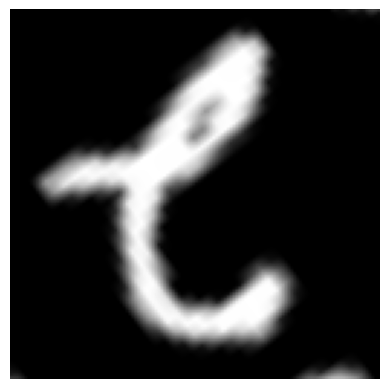

1/1 [==============================] - 0s 169ms/step
Prediction scores from the output layer(Without SoftMax):  [[1.3620928e-01 6.4240664e-02 3.5020925e-02 1.2097477e-03 5.7123380e-05
  9.6436674e-03 6.5726423e-01 8.4190890e-03 8.7759167e-02 1.7611591e-04]]
Predicted label: 6


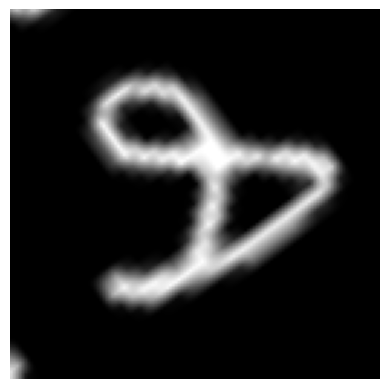

1/1 [==============================] - 0s 22ms/step
Prediction scores from the output layer(Without SoftMax):  [[1.2587114e-03 2.0279272e-03 4.0586177e-02 8.4936609e-03 2.2886827e-04
  1.3434163e-03 5.0816877e-04 9.1313940e-01 3.2299820e-02 1.1384498e-04]]
Predicted label: 7


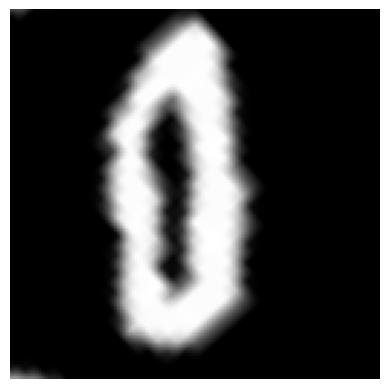

1/1 [==============================] - 0s 21ms/step
Prediction scores from the output layer(Without SoftMax):  [[1.0305253e-03 2.3104278e-03 2.2322771e-05 5.2413307e-06 2.5267637e-04
  2.3920559e-03 9.4770640e-01 2.0560238e-04 4.6009298e-02 6.5450040e-05]]
Predicted label: 6


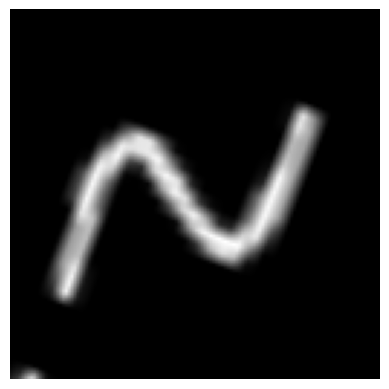

1/1 [==============================] - 0s 33ms/step
Prediction scores from the output layer(Without SoftMax):  [[2.6284489e-03 4.6666079e-05 2.6263876e-02 6.3717111e-05 9.6586078e-01
  1.0352507e-05 2.3668092e-04 3.7877525e-03 7.0877461e-04 3.9288585e-04]]
Predicted label: 4


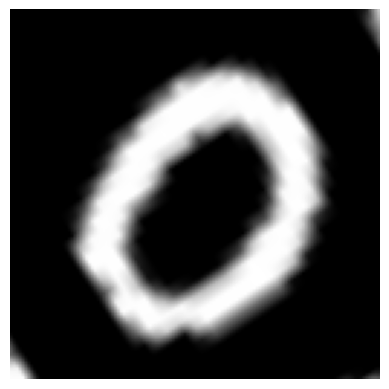

1/1 [==============================] - 0s 24ms/step
Prediction scores from the output layer(Without SoftMax):  [[9.9999440e-01 8.7733270e-09 4.7418953e-07 6.4910985e-08 1.3717916e-09
  4.4063677e-07 4.9083746e-07 1.8050417e-06 2.1721370e-07 2.0958469e-06]]
Predicted label: 0


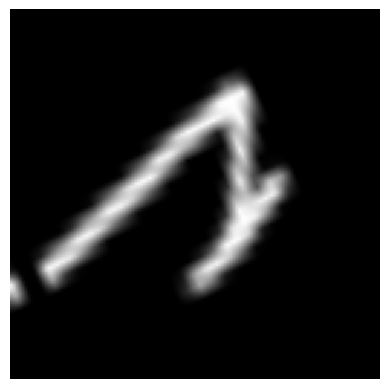

1/1 [==============================] - 0s 25ms/step
Prediction scores from the output layer(Without SoftMax):  [[2.3010281e-01 6.9306680e-04 2.6231168e-02 2.2229915e-03 1.7115675e-01
  4.6361391e-05 4.3784111e-04 5.5937934e-01 9.5064600e-04 8.7790014e-03]]
Predicted label: 7


In [ ]:
real_life_data = data_augment(val_ds, shuffle=True, augment=True, batch_size=6)

# Question 3:  Load the model that we saved in the previous cell. (1 Point)
# Write your code here
model = tf.keras.models.load_model('epic_num_classification.model')


# Loss and Accuracy
loss, acc = model.evaluate(real_life_data)
print("Accuracy", acc)


X, y = next(iter(real_life_data))
def show_image_prediction(X, y):

    for i in  range(len(X)):
        image = X[i]
        label = y[i]
        plt.imshow(np.squeeze(image), cmap='gray')
        plt.axis('off')
        plt.show()

        # Expand the validation image to (1, 128, 128, 3) before predicting the label
        prediction_scores = model.predict(np.expand_dims(image, axis=0))

        # The prediction scores are the output form the last layer
        print("Prediction scores from the output layer(Without SoftMax): ", prediction_scores)

        # Then we do an argmax over that list to find the one wiht the highest value and get the index
        predicted_index = np.argmax(prediction_scores)
        #print(predicted_index)

        # Finally we use the get_label_name function to convert the integer index value into a string predicted label
        print("Predicted label: " + get_label_name(predicted_index))

show_image_prediction(X, y)

## **How to address this issue? or in another word, make sure CNN is rotation and scale invariant ?**
### Now we will create augmented training data by calling the **data_augment** fucntion we defined

#### Test and evaluate the model with out-of-sample dataset

Now you will be able to see that the accuracy of the model is restored and it is over 90%

In [ ]:
augmented_train_ds = data_augment(train_ds, shuffle=True, augment=True)

epochs=3
history = model.fit(
  augmented_train_ds,
  epochs=epochs
)

Epoch 1/3
1500/1500 [==============================] - 55s 36ms/step - loss: 1.2596 - accuracy: 0.5785
Epoch 2/3
1500/1500 [==============================] - 52s 34ms/step - loss: 0.8696 - accuracy: 0.7136
Epoch 3/3
1500/1500 [==============================] - 51s 34ms/step - loss: 0.7512 - accuracy: 0.7546


## Now again we will evaluate and predict image using our old, real life data.

See how the accuracy improves and see the real examples of images along with their prediction.

1000/1000 [==============================] - 7s 7ms/step - loss: 0.4968 - accuracy: 0.8483
Accuracy 0.8483333587646484


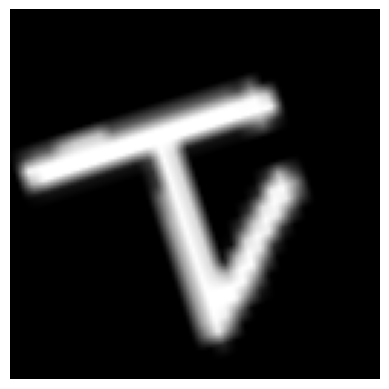

1/1 [==============================] - 0s 32ms/step
Prediction scores from the output layer(Without SoftMax):  [[6.8073248e-05 9.7300252e-03 2.5960499e-01 8.9616596e-04 2.6063719e-01
  3.0848924e-02 7.1306415e-03 3.2527959e-01 1.1710622e-02 9.4093718e-02]]
Predicted label: 7


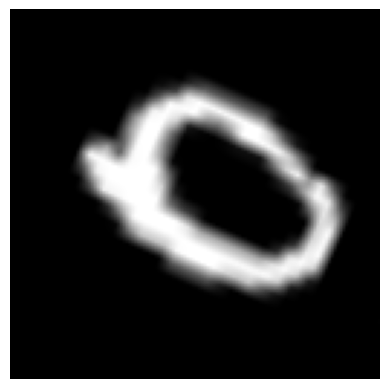

1/1 [==============================] - 0s 26ms/step
Prediction scores from the output layer(Without SoftMax):  [[7.4586880e-01 1.7161515e-08 5.4110917e-03 5.9467205e-04 1.2509583e-03
  1.9330798e-02 2.1409038e-01 8.5273007e-04 4.3432080e-04 1.2166246e-02]]
Predicted label: 0


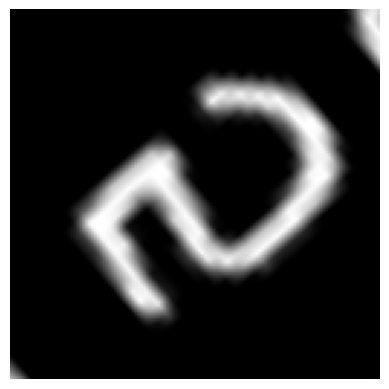

1/1 [==============================] - 0s 31ms/step
Prediction scores from the output layer(Without SoftMax):  [[1.0921941e-02 8.0850143e-08 1.0906359e-02 7.8600116e-02 1.8284023e-05
  7.9517299e-01 9.2998855e-02 1.5478918e-05 5.0204592e-03 6.3454174e-03]]
Predicted label: 5


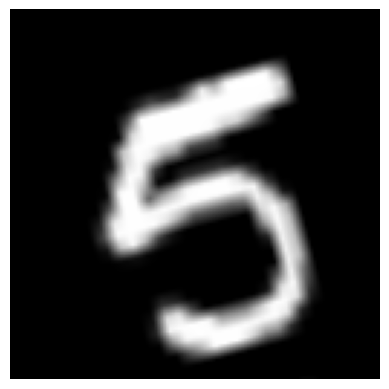

1/1 [==============================] - 0s 31ms/step
Prediction scores from the output layer(Without SoftMax):  [[1.69891762e-04 1.51077177e-08 1.20689848e-03 4.32623848e-02
  9.05469904e-07 9.37067211e-01 1.17884185e-02 1.29604155e-06
  2.47054501e-03 4.03251313e-03]]
Predicted label: 5


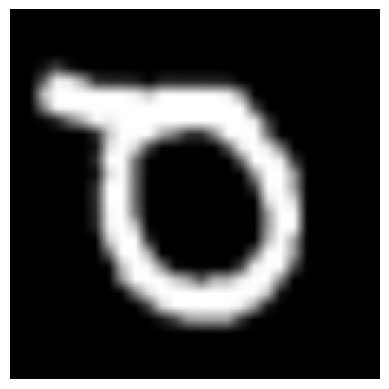

1/1 [==============================] - 0s 29ms/step
Prediction scores from the output layer(Without SoftMax):  [[9.6080548e-01 5.4388433e-10 1.1399226e-03 1.4936111e-06 2.3202403e-05
  9.0155903e-05 3.6549706e-03 7.0316449e-04 1.9504667e-07 3.3581458e-02]]
Predicted label: 0


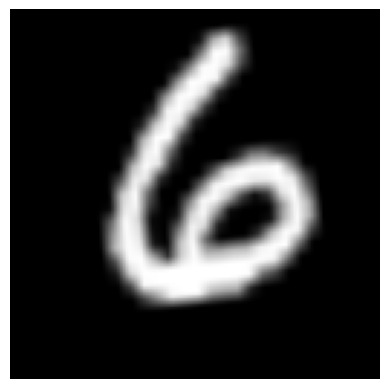

1/1 [==============================] - 0s 29ms/step
Prediction scores from the output layer(Without SoftMax):  [[2.75044760e-04 8.03576228e-09 2.35638858e-04 9.00360174e-05
  1.32529212e-05 5.54708345e-03 9.86615181e-01 1.10266374e-04
  1.23530524e-04 6.98991958e-03]]
Predicted label: 6


In [ ]:
loss, acc = model.evaluate(real_life_data)
print("Accuracy", acc)

X, y = next(iter(real_life_data))
show_image_prediction(X, y)

## Explain why re-training the model with new augmented dataset helped improve the acuracy of the model?


In [ ]:
# Question 4: Summarize your learning in 2 sentences (1 Point)

# Write your answer here
answer = '''
Earlier we were training out dataset with and testing with different dataset. But second time we used augmented data
as well for the training that helped the model to understand the test data set better. So the accuracy improved.
'''
print(answer)



Earlier we were training out dataset with and testing with different dataset. But second time we used augmented data
as well for the training that helped the model to understand the test data set better. So the accuracy improved. 



## Transfer Learning

Transfer learning involves taking a pre-trained neural network and adapting the neural network to a new, different data set with different task. In general, a Deep Learning model requires a lot of training data to acheive a good accuraccy. But there could be case where a large amount of training data is very scarce. In those cases, Transfer Learning comes in handy.

While there are different Transfer Learning method based on the similarity and dataset size of the down task, I would like to show you one particular case:  

**New data set is small, new data is similar to original training data.**
In this case we are going to freeze the weight update of the original model, and only updating the weights of the classification layer is sufficcient. Example to be shown in the following cell.

But if the new data is not similar with the previously trained data, the technique we use to solve this issue is called Fine Tuning, where we do not freeze the weight update of the original model.


In the following section we are going to use a pre-trained model called **Xception** trained on **ImageNet** dataset. Our goal is to train a relatively smaller dataset of flowers. A pre-trained model is a type of model which is already trained on a large dataset and could be used as a feature extractor for the classification layer. Classification layer means the Dense/Linear layer that we typically use in a neural network. This feature extractor can learn meaningful features from a image. In this example the weights of the feature extractor will be frozen.  However, the final, classification layer of our model will be specific to the original flower classification task.

![alt text](https://miro.medium.com/max/1400/1*qfQ3hmHLwApXZBN-A85r8g.png "Transfer Learning")

Image courtesy and for a more detailed understanding of Transfer Learning please read [Medium](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)




Consider the image above. In the left hand side, we have a model(in our case **Xception**) which is trained on a large dataset(**ImageNet**). Then we tear-up/remove the classification layers(Green Layers) and attach remaining CNN layers(Green Layer) with a different classifier(Green Layer) on the Right hand side. Then we can freeze the CNN layer(Blue Layer) and train the Classifier Layer. Otherwise we can fine tune the CNN layers along with the classifiers without freezing the model which is also known as Fine-Tuning.




## Loading Dataset

For this task, we will use *tf_flowers* dataset and call our previously defined *prepare* function to get train, test and validation batches. Then we will find the number of classes and a function  to convert the numbered labels to string labels.


In [ ]:
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow import keras

(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

flower_train_ds = data_augment(train_ds, shuffle=True, augment=True)
flower_val_ds = data_augment(val_ds, shuffle=True, augment=True)
flower_test_ds = data_augment(test_ds, shuffle=True, augment=True)

num_classes = metadata.features['label'].num_classes
print("Number of classes we want to classify", num_classes)
get_label_name = metadata.features['label'].int2str

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Number of classes we want to classify 5


Then we are going to load Xception model which is trained on ImageNet Dataset and freeze this layer

In [ ]:
# (128, 128, 3) is the shape of the input images
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(128, 128, 3),
    include_top=False)

# Freeze base model
base_model.trainable = False

83683744/83683744 [==============================] - 0s 0us/step


## Complete the model

Initial part to add the base model and GlobalAveragePooling2D is done for you. Complete the rest of the Dense layer, and rest of the parts according to the instruction. Also see how fast we were able to train our model compared to the previous ones.

In [ ]:
model = Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())

# Question 5: Write the code to construct the Dense layer for the model (1 point)

#Write your code here
# Final Dense layers for classification
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
# Final Dense layers for classification
model.add(tf.keras.layers.Dense(1024, activation='relu'))
# Converting to probability domain using Softmax
model.add(tf.keras.layers.Dense(5, activation='softmax'))
model.summary()


# Learning Rate
base_learning_rate = 0.001


# Question 6: Compile the model (1 point)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


# Number of Epochs
epochs=5

# Question 7: Train and Evaluate the model and show the accuracy (1 point)
# Write your code here
epochs=3
history = model.fit(
  flower_train_ds,
  epochs=epochs
)

loss, acc = model.evaluate(flower_test_ds)
print("Test Accuracy", acc)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_4 (Dense)             (None, 5)                 5125      
                                                      

## Try out the model on an image from the outside data

This section is for learning pusposes only. Outside data means, data that the model has never seen and compared to random real life data.

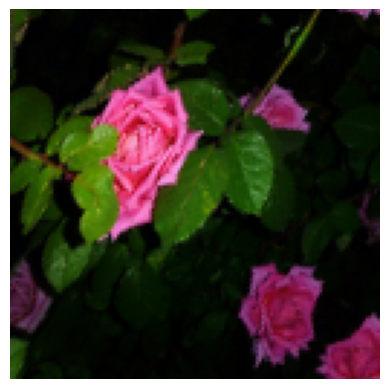

1/1 [==============================] - 1s 1s/step
Prediction scores from the output layer(Without SoftMax):  [[0.03822202 0.0794418  0.27149776 0.15353292 0.4573055 ]]
Predicted label: roses


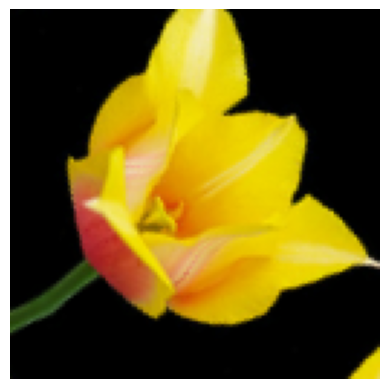

1/1 [==============================] - 0s 23ms/step
Prediction scores from the output layer(Without SoftMax):  [[0.00203439 0.00351478 0.6595024  0.00648672 0.3284617 ]]
Predicted label: tulips


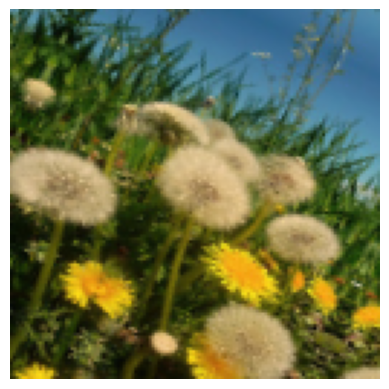

1/1 [==============================] - 0s 22ms/step
Prediction scores from the output layer(Without SoftMax):  [[0.8769649  0.00971195 0.05233112 0.01419317 0.0467988 ]]
Predicted label: dandelion


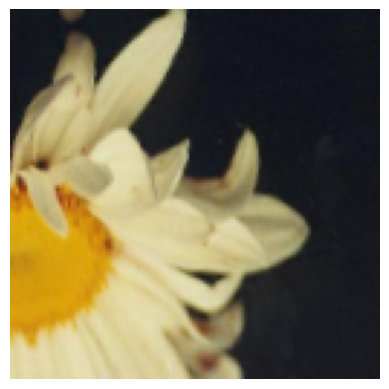

1/1 [==============================] - 0s 22ms/step
Prediction scores from the output layer(Without SoftMax):  [[0.00619162 0.60164565 0.34518537 0.00535683 0.04162059]]
Predicted label: daisy


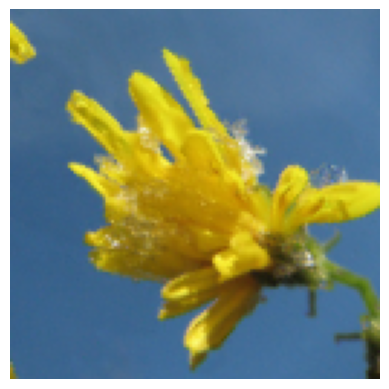

1/1 [==============================] - 0s 25ms/step
Prediction scores from the output layer(Without SoftMax):  [[0.4654115  0.07143446 0.21947482 0.07826088 0.16541831]]
Predicted label: dandelion


In [ ]:
# Extract a single image from the Validation Dataset.
# X is the image matrices and y is the labels(int value)
X, y = next(iter(flower_val_ds))

# Showing 6 random image
show_image_prediction(X[:5], y[:5])


In [ ]:
# Question 8: Summarize your learning in 2 sentence (1 Point)

# Write your answer here
answer2 = '''
For second training it took less time than earlier. Because we used tranfer learning here. We used a already trained
model with our new model. So training time reduced and our model can predict better as well.
'''
print(answer2)


For second training it took less time than earlier. Because we used tranfer learning here. We used a already trained
model with our new model. So training time reduced and our model can predict better as well.

